# MARBLE Training Example with Time-Aligned EEG Data

This notebook demonstrates how to use the functions in `data_processing.py` to train MARBLE models on EEG data with time-aligned labels.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from glob import glob
import mne
import torch
import pickle

import MARBLE
from MARBLE import postprocessing, plotting

from data_processing import *

## Example 3: Load and process EEG data

Now let's load some EEG data from files and process it for MARBLE.

Found 6 preprocessed datasets:
  1. 20240816_000000_20240816_000000_PreMARBLE_dataset.npz
  2. 20240816_000000_20240816_135705_PreMARBLE_dataset.npz
  3. 20240816_000000_20240819_194858_PreMARBLE_dataset.npz
  4. 20240816_000000_20240823_182713_bandpower_80-250Hz_PreMARBLE_dataset.npz
  5. 20240816_000000_20240823_220200_PreMARBLE_dataset.npz
  6. 20240816_000000_20240827_153109_PreMARBLE_dataset.npz
Loaded preprocessed data with shape: (100, 60000, 6)
Loaded labels with shape: (100, 60000, 1)
Loaded preprocessed data from temp_Data/20240816_000000_20240827_153109_PreMARBLE_dataset.npz
Loaded data shape: (100, 60000, 6)
Time array shape: (100, 60000, 1)


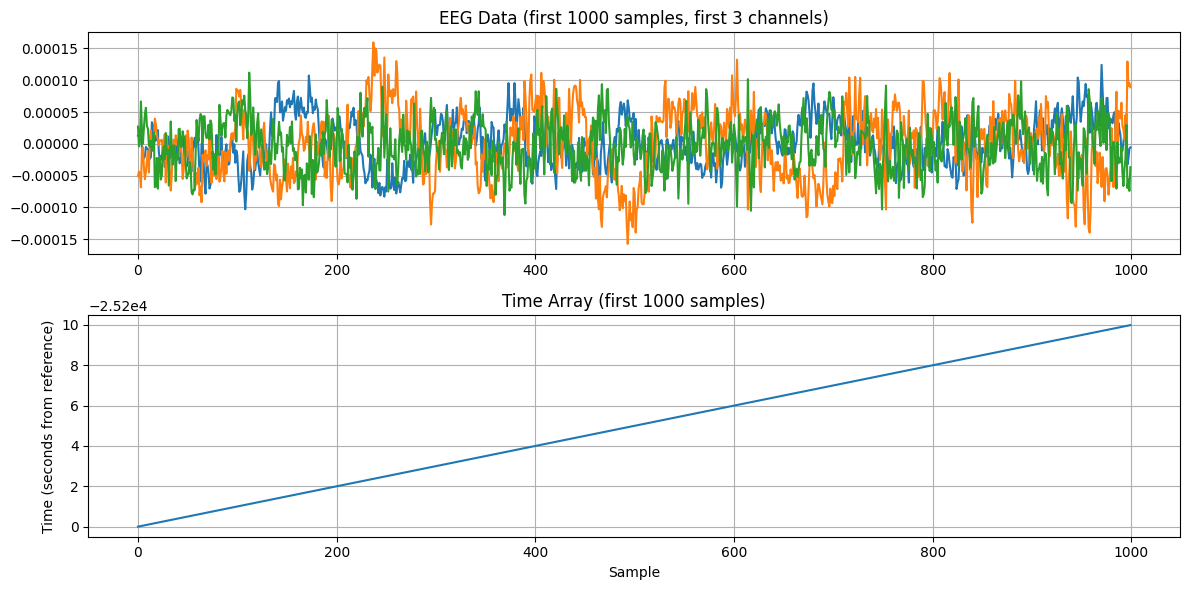

In [2]:
load_dataset = True  # Whether to load preprocessed dataset

# Define parameters
data_dir = "./preprocessed/bipolar"
max_samples = 10000  # Use a smaller number for demonstration
batch_size = 20  # Number of batches to create
max_files = None  # Maximum number of files to read
resample_freq = 50  # Resampling frequency in Hz
save_data = True  # Whether to save preprocessed data
save_dir = "temp_Data"  # Directory to save preprocessed data
label_type = "time"

if load_dataset:
    # Find available preprocessed datasets
    dataset_files = find_preprocessed_datasets(save_dir)
    if dataset_files:
        # Load the most recent dataset
        batch_data, batch_times = load_preprocessed_data(dataset_files[-1])
        print(f"Loaded preprocessed data from {dataset_files[-1]}")
        used_files = []  # No file tracking needed when loading preprocessed
        next_file_idx = 0
    else:
        print("No preprocessed datasets found, loading from raw files...")
        load_dataset = False

if not load_dataset:
    # Load data from raw files
    batch_data, batch_times, used_files, next_file_idx = load_merged_data(
        data_dir=data_dir,
        max_samples=max_samples,
        batch_size=batch_size,
        max_files=max_files,
        resample_freq=resample_freq,
        save_data=save_data,
        save_dir=save_dir,
        label_type=label_type,
    )

print(f"Loaded data shape: {batch_data.shape}")
print(f"Time array shape: {batch_times.shape}")
if not load_dataset:
    print(f"Used {len(used_files)} file(s)")
    print(f"Next file index: {next_file_idx}")

# Plot samples from first batch to check data quality
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(batch_data[0, :1000, :3])  # First batch, first 1000 samples, first 3 channels
plt.title('EEG Data (first 1000 samples, first 3 channels)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(batch_times[0, :1000])  # First batch, first 1000 time points
plt.title('Time Array (first 1000 samples)')
plt.xlabel('Sample')
plt.ylabel('Time (seconds from reference)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Example 4: Prepare data for MARBLE

In [3]:
# Prepare data for MARBLE
pos_list, x_list, labels = prepare_MARBLE_data(batch_data, batch_times)

Created 100 batches of data
Position shape: (59999, 6)
Vector shape: (59999, 6)
Labels shape: (59999, 1)


## Example 5: Train a MARBLE model with time labels

In [9]:
# Define flags for loading saved data/model
load_dataset = True 
load_model = True
from MARBLE import utils
# Define save paths
save_path = 'temp_Data/eeg_dataset.pkl'
model_path = 'temp_Data/eeg_model.pkl'

# Define MARBLE parameters
params = {
    "epochs": 100,  # Use fewer epochs for demonstration
    "order": 1,
    "hidden_channels": [256,128,64],
    "batch_size": 256,
    "lr": 1e-3,
    "momentum": 0.9, 
    "weight_decay": 1e-4,
    "out_channels": 5,
    "inner_product_features": False,
    "diffusion": False,
    "batch_norm": True,
    "seed": 42,
}

# # Construct or load dataset
k_value = 500
if not load_dataset:
    Dataset = MARBLE.construct_dataset(
        anchor=pos_list, 
        vector=x_list,
        label=labels,  # Use time-based labels
        graph_type="cknn",
        k=k_value,  
        Sampling=False,
        number_of_eigenvectors=500,
    )
    with open(save_path, 'wb') as f:
        pickle.dump(Dataset, f)
    print(f"Dataset saved to {save_path}")
else:
    with open(save_path, 'rb') as f:
        Dataset = pickle.load(f)
    print(f"Dataset loaded from {save_path}")

# # Train or load model

model = MARBLE.net(Dataset, params=params)

if not load_model:
    # Clear GPU memory before training
    torch.cuda.empty_cache()
    model.fit(Dataset)
    # Move model back to CPU before saving
    model = model.cpu()
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {model_path}")
else:
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {model_path}")

# Force model to CPU for transform to avoid CUDA OOM
model = model.cpu()

# Process dataset in batches instead of all at once
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch

# Convert to a list of individual data objects if needed
if not isinstance(Dataset, list):
    data_list = [Dataset]
else:
    data_list = Dataset

# Create a custom transform function that processes data on CPU
def transform_on_cpu(model, data):
    # Ensure everything is on CPU
    model = model.cpu()
    
    # The original transform function will try to move data to GPU
    # This is handled in MARBLE's move_to_gpu and detach_from_gpu functions
    # We'll process on CPU and handle GPU memory manually
    with torch.no_grad():
        # Create the adjacency structure
        size = (data.x.shape[0], data.x.shape[0])
        adjs = utils.EdgeIndex(data.edge_index, torch.arange(data.edge_index.shape[1]), size)
        adjs = utils.to_list(adjs) * model.params["order"]
        
        # Transform data (entirely on CPU)
        result = model.forward(data, torch.arange(len(data.x)), adjs)
        data.emb = result[0].detach()
        
        return data

# Apply the transform
transformed_Dataset = transform_on_cpu(model, Dataset)

# Continue with post-processing (also on CPU)
Dataset = postprocessing.embed_in_2D(transformed_Dataset)
Dataset = MARBLE.distribution_distances(transformed_Dataset)

Dataset loaded from temp_Data/eeg_dataset.pkl

---- Settings: 

epochs : 100
order : 1
hidden_channels : [256, 128, 64]
batch_size : 256
lr : 0.001
momentum : 0.9
weight_decay : 0.0001
out_channels : 5
inner_product_features : False
diffusion : False
batch_norm : batch_norm
seed : 42
dropout : 0.0
bias : True
frac_sampled_nb : -1
include_positions : False
include_self : True
vec_norm : False
emb_norm : False
dim_signal : 6
dim_emb : 6
n_sampled_nb : -1

---- Number of features to pass to the MLP:  42
---- Total number of parameters:  53382

Using device cuda:0
Model loaded from temp_Data/eeg_model.pkl


/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Performed umap embedding on embedded results.


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/home/honglab/leijiaxin/anaconda3/envs/MARBLE/lib/python3.9/site-packages/ot/lp/__init__.py:547: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max numb

In [31]:
Dataset

DataBatch(x=[189981, 6], edge_index=[2, 77216661], y=[189981], pos=[189981, 6], label=[189981, 1], mask=[189981], edge_weight=[77216661], num_nodes=189981, num_node_features=[19], sample_ind=[189981], batch=[189981], ptr=[20], degree=500, number_of_resamples=0, train_mask=[189981], val_mask=[189981], test_mask=[189981], kernels=[6], L=[2], gauges=[189981, 6, 6], local_gauges=False, emb=[189981, 5], emb_2D=[189981, 2], manifold=UMAP(n_jobs=1, random_state=0, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}), dist=[19, 19])

In [ ]:
from MARBLE import geometry

# Visualize embeddings
plt.figure(figsize=(4, 4))

ax = plotting.embedding(Dataset, Dataset.label.numpy().flatten().astype(int))
plt.title('MARBLE Embedding')
plt.savefig('temp_Figures/eeg_marble_embedding.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6.4, 4.8))
im = plt.imshow(Dataset.dist)

# Plot different embeddings
embed_types = ['PCA', 'tsne', 'umap', 'Isomap', 'MDS']

for embed_typ in embed_types:
    emb, _ = geometry.embed(Dataset.dist, embed_typ=embed_typ)
    plt.figure(figsize=(4, 4))
    ax = plotting.embedding(emb, s=30, alpha=1)
    plt.title(f'{embed_typ} Embedding')
    plt.savefig(f'temp_Figures/eeg_{embed_typ.lower()}_embedding.png', dpi=300, bbox_inches='tight')
    plt.show()

print("=" * 40)
print("Results saved to temp_Figures/ directory.")

You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot trajectories!
You need to pass a data object to plot traject

KeyboardInterrupt: 